In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils import *

from sklearn.model_selection import GridSearchCV
from best_estimator import create_x_y_from_cohort
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Jupyter doesnt import again the module if it changed so we reload the module to overcome this
import importlib, sys
importlib.reload(sys.modules['utils'])
importlib.reload(sys.modules['best_estimator'])

<module 'best_estimator' from '/home/adiha2@mta.ac.il/jupjup/best_estimator.py'>

In [2]:
model_pickle_path = "model.pkl"

In [3]:
X_train, X_test, y_train, y_test = create_x_y_from_cohort()

[2024-08-29 10:39:18,479]:[best_estimator : 22]:[INFO    ] - Creating the cohort
[2024-08-29 10:39:23,504]:[create_cohort  : 39]:[INFO    ] - Dropping column 31-0.0
[2024-08-29 10:39:23,673]:[create_cohort  : 43]:[INFO    ] - Creating label column
[2024-08-29 10:39:23,766]:[create_cohort  : 48]:[INFO    ] - Dropping columns ('Source of report of N80 (endometriosis)', 'Date N80 first reported (endometriosis)')
[2024-08-29 10:39:23,910]:[create_cohort  : 52]:[INFO    ] - Sampling patients
[2024-08-29 10:39:24,187]:[create_cohort  : 62]:[INFO    ] - Preprocessing categorical features
[2024-08-29 10:39:24,481]:[create_cohort  : 70]:[INFO    ] - Adding estrogen exposure column
[2024-08-29 10:39:24,810]:[create_cohort  : 88]:[INFO    ] - Adding number of diagnoses column
[2024-08-29 10:39:33,597]:[best_estimator : 29]:[INFO    ] - Splitting to X and y


Finished creating cohort


In [4]:
with open(model_pickle_path, 'rb') as f:
    clf_grid = pickle.loads(f.read())

In [5]:
cb_model = clf_grid.best_estimator_

In [7]:
num_feats_to_display = 13

importances = cb_model.get_feature_importance()

features = X_train.columns.to_series().apply(code_to_feature)
sorted_indices = np.argsort(importances)[::-1][:num_feats_to_display]

In [8]:
sorted_importances = importances[sorted_indices]
sorted_features = features[sorted_indices]

In [9]:
sorted_features = ['Has gyno conditions', 'Estrogen exposure', 'Menstruating today', 'Age at recruitment ', 'Diagnosis count',
                   'Excessive menstruation', 'Has pelvic pain', 'Female infertility', 'Has Menstrual pain', 'Gave birth', 'Number of births', 
                   'Age at menarche', 'Abdominal pain']

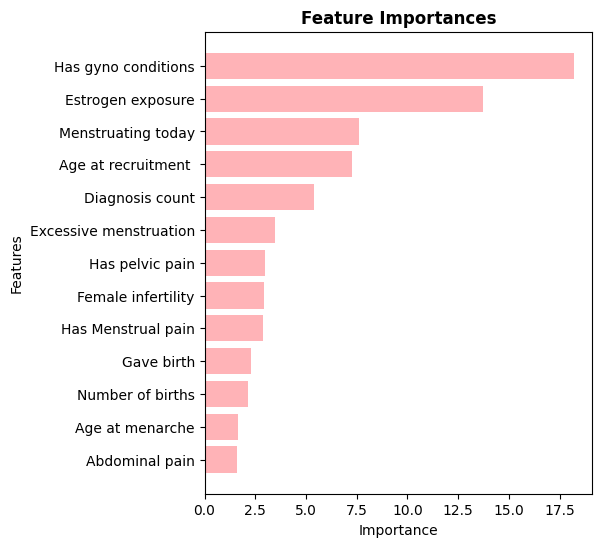

In [10]:
# Create the horizontal bar chart
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(sorted_features[::-1], sorted_importances[::-1], color='#FFB3B7')

# Set the x-axis label
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Feature Importances', weight='bold')
ax.grid(False)

# Adjust the spacing between the bars and the y-axis labels
#plt.subplots_adjust(left=0.4, right=0.9, top=0.9, bottom=0.3)

In [11]:
y_pred = cb_model.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7327841845140033
Precision: 0.7415500170706726
Recall: 0.7151794534079684
F1 Score: 0.7281260476030842


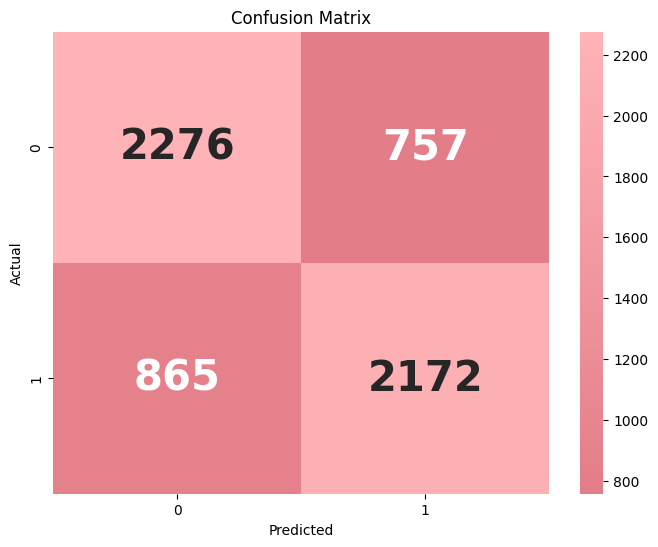

In [13]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

cm = confusion_matrix(y_test, y_pred)
colors = ['#AC102A', '#FFB3B7']
custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, center=True, cmap=custom_cmap, annot=True, fmt='g', ax=ax, annot_kws = {"weight": "bold", "size": 30})

# Set the text color for the annotations
#annot_kws = {"color": "white", "weight": "bold"}

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

plt.show()

In [14]:
import shap

explainer = shap.TreeExplainer(cb_model)
explanation = explainer(X_test)

shap_values = explanation.values

# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

3.295375585249313

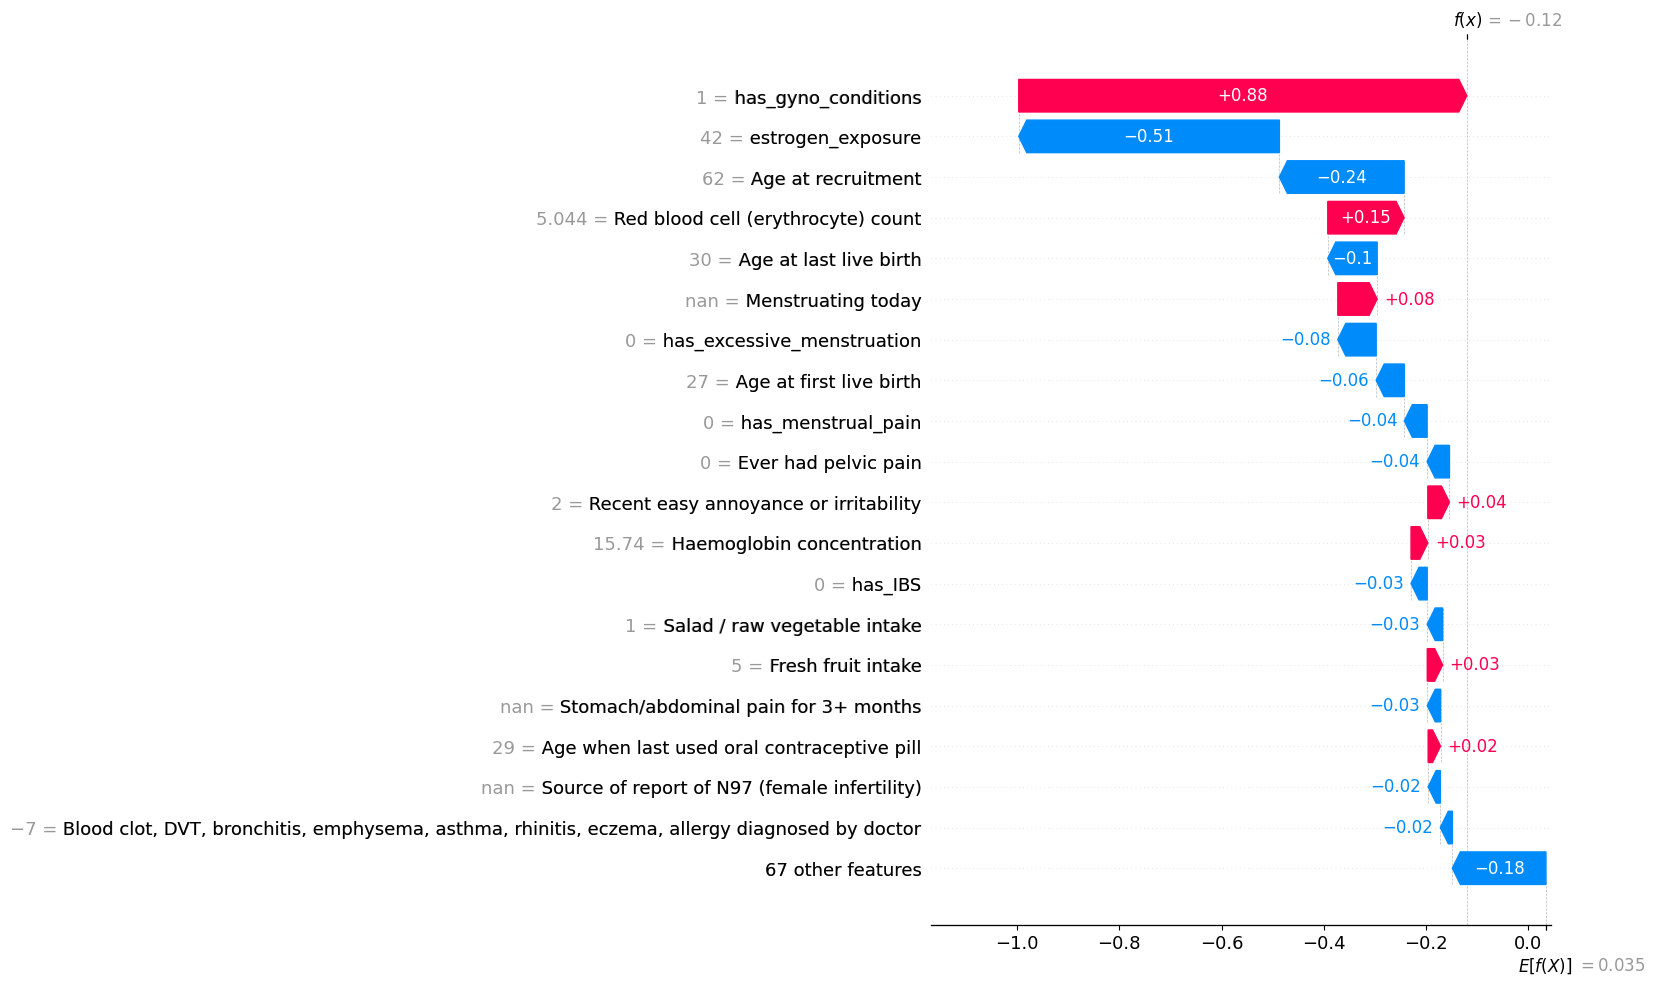

In [16]:
shap.plots.waterfall(explanation[0], max_display=20, show=True)

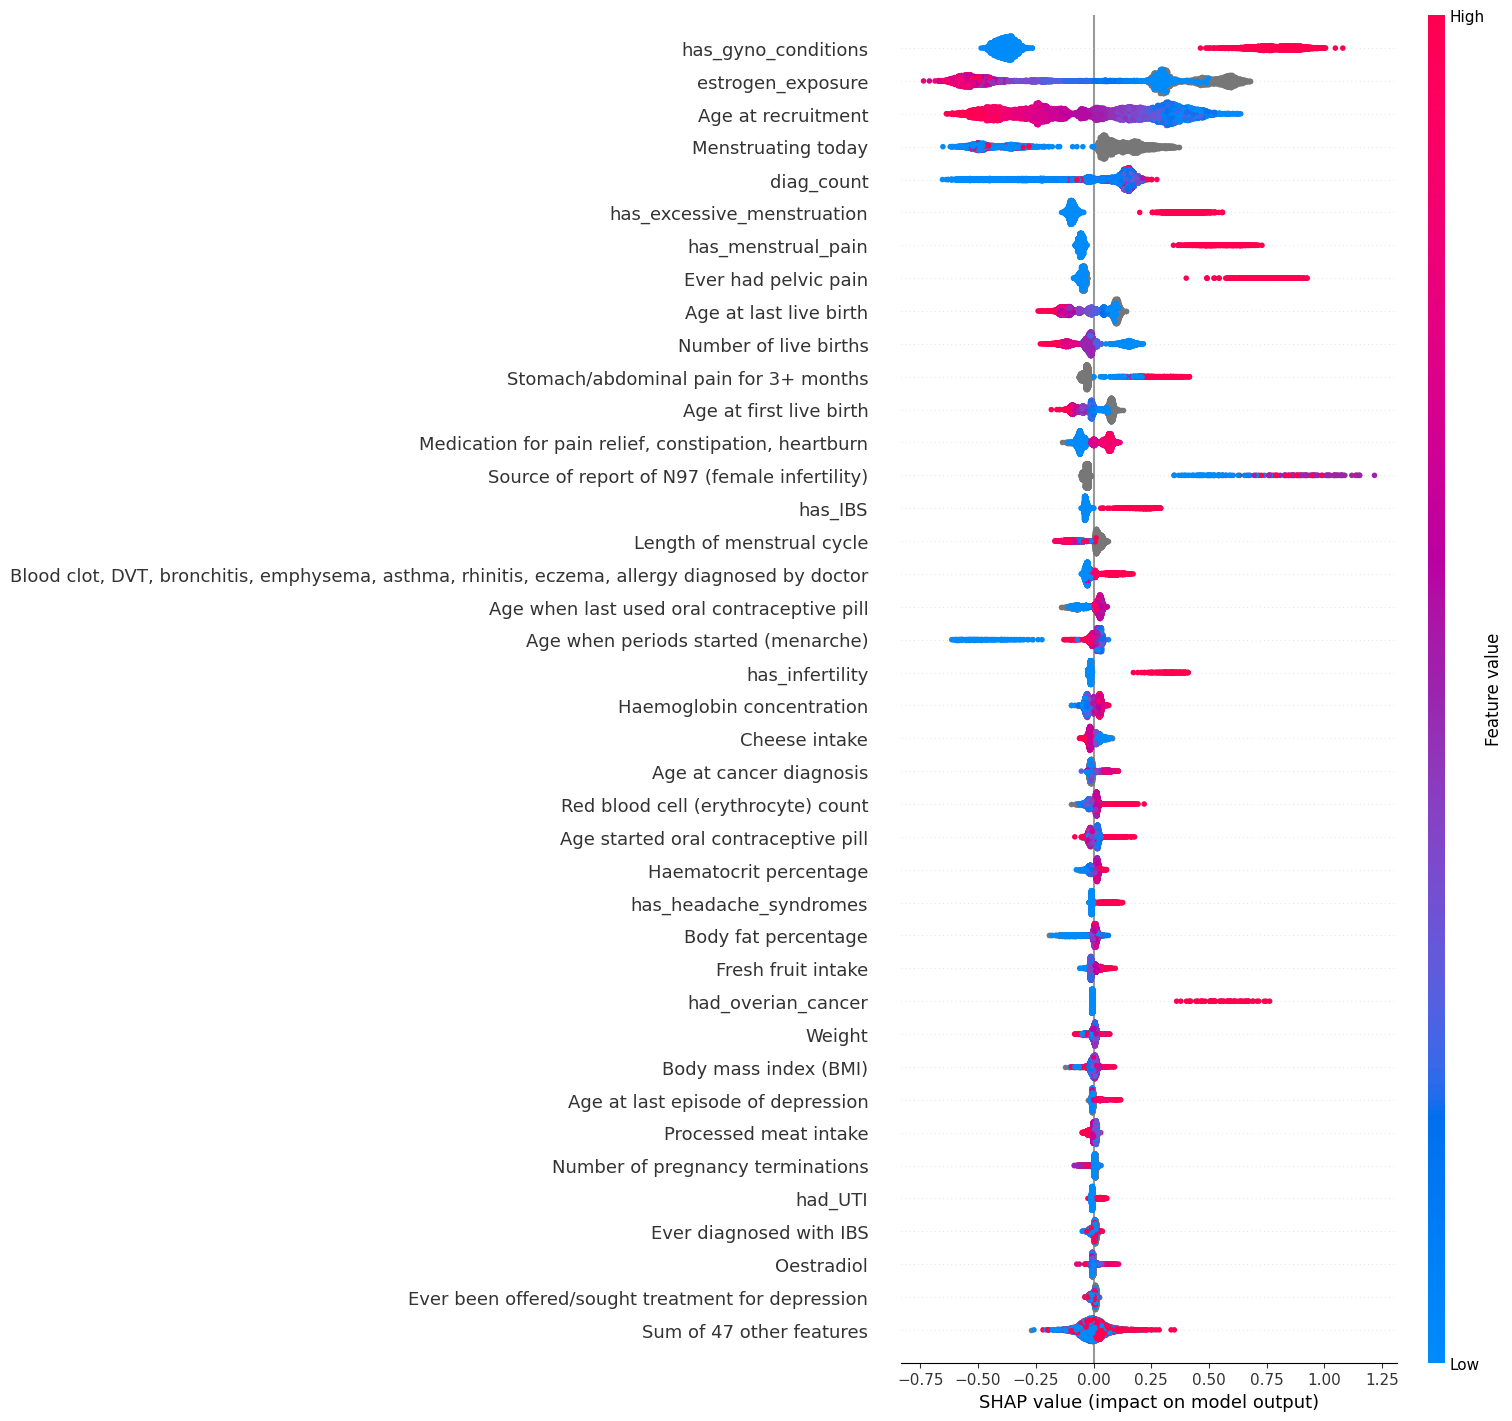

In [17]:
shap.plots.beeswarm(explanation, max_display=40, show=True)

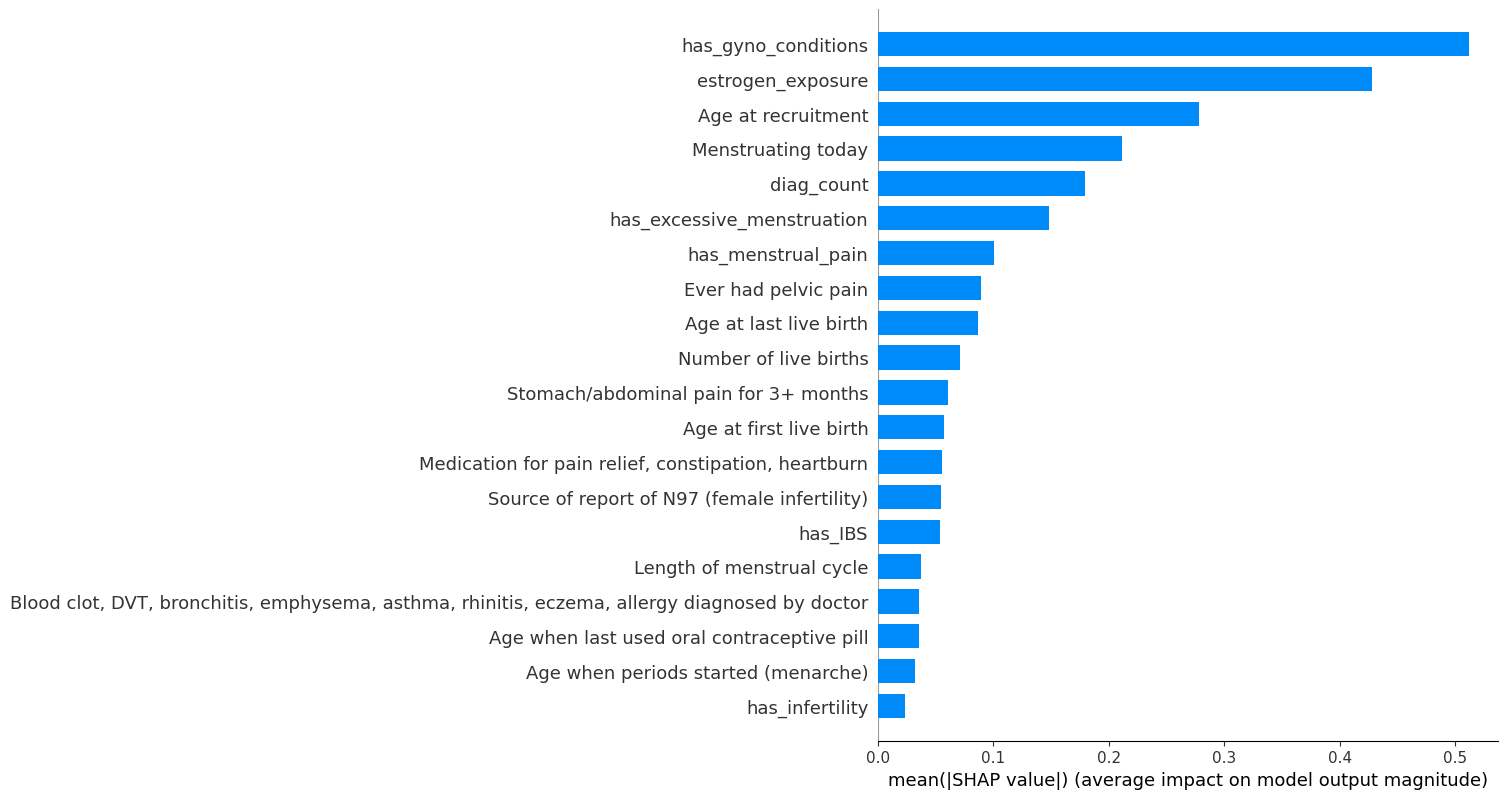

In [22]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test.values, plot_type="bar", class_names=['Class 0', 'Class 1'], show=False, feature_names=X_test.columns)
plt.tight_layout()
plt.show()